In [1]:
from scipy.linalg import svd
from scipy.linalg import eig
from numpy import *
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.utils.extmath import randomized_svd
import operator

cln=6


In [2]:
#Name: status.py
# coding=utf-8



class Status(object):
    node_to_cluster = {}
    total_weight = 0
    internals = {}
    degrees = {}
    gdegrees = {}

    def __init__(self):
        self.node_to_cluster = dict([])
        self.total_weight = 0
        self.degrees = dict([])
        self.gdegrees = dict([])
        self.internals = dict([])
        self.loops = dict([])

    def __str__(self):
        return ("node_to_cluster : " + str(self.node_to_cluster) + " degrees : "
                + str(self.degrees) + " internals : " + str(self.internals)
                + " total_weight : " + str(self.total_weight))

    def copy(self):
        new_status = Status()
        new_status.node_to_cluster = self.node_to_cluster.copy()
        new_status.internals = self.internals.copy()
        new_status.degrees = self.degrees.copy()
        new_status.gdegrees = self.gdegrees.copy()
        new_status.total_weight = self.total_weight

    def initialization(self, graph, weight, part=None):
        count = 0
        self.node_to_cluster = dict([])
        self.total_weight = 0
        self.degrees = dict([])
        self.gdegrees = dict([])
        self.internals = dict([])
        self.total_weight = graph.size(weight=weight)
        if part is None:
            for node in graph.nodes():
                self.node_to_cluster[node] = count
                deg = float(graph.degree(node, weight=weight))
                if deg < 0:
                    error = "Bad node degree ({})".format(deg)
                    raise ValueError(error)
                self.degrees[count] = deg
                self.gdegrees[node] = deg
                edge_data = graph.get_edge_data(node, node, default={weight: 0})
                self.loops[node] = float(edge_data.get(weight, 1))
                self.internals[count] = self.loops[node]
                count += 1
        else:
            for node in graph.nodes():
                com = part[node]
                self.node_to_cluster[node] = com
                deg = float(graph.degree(node, weight=weight))
                self.degrees[com] = self.degrees.get(com, 0) + deg
                self.gdegrees[node] = deg
                inc = 0.
                for neighbor, datas in graph[node].items():
                    edge_weight = datas.get(weight, 1)
                    if edge_weight <= 0:
                        error = "Bad graph type ({})".format(type(graph))
                        raise ValueError(error)
                    if part[neighbor] == com:
                        if neighbor == node:
                            # inc += float(edge_weight)
                            # Modified:
                            inc += float(edge_weight) / 2.
                        else:
                            inc += float(edge_weight) / 2.
                self.internals[com] = self.internals.get(com, 0) + inc

In [3]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

# load the karate club graph
#G = nx.karate_club_graph()


data = pd.read_csv("snn.csv", encoding= 'unicode_escape')
l=data.shape
print(l)
Adj=data.to_numpy()
print(np.shape(Adj))
G = nx.from_numpy_matrix(Adj)

(4743, 4743)
(4743, 4743)


In [4]:
#cluster_louvain.py


from __future__ import print_function

import array

import numbers
import warnings

import networkx as nx
import numpy as np

from cluster_status import Status

__author__ = """Thomas Aynaud (thomas.aynaud@lip6.fr)"""
#    Copyright (C) 2009 by
#    Thomas Aynaud <thomas.aynaud@lip6.fr>
#    All rights reserved.
#    BSD license.
#    some problems were fixed by Miryam Huang

MAX_PASS = -1
_MIN = 0.0000001


def check_random_s(seed):
    if seed is None: 
        return np.random.mtrand._rand
    if seed is np.random:
        return np.random.mtrand._rand
    if isinstance(seed, (numbers.Integral, np.integer)):
        return np.random.RandomState(seed)
    if isinstance(seed, np.random.RandomState):
        return seed
    raise ValueError("%r cannot be used to seed a numpy.random.RandomState"
                     " instance" % seed)


def leveled_cluster(dendrogram, level):
    # Return the cluster of the nodes at the given level i.e. leveled_cluster (l_cluster)

    l_cluster = dendrogram[0].copy()
    for i in range(1, level + 1):
        for node, cluster in l_cluster.items():
            l_cluster[node] = dendrogram[i][cluster]
    return l_cluster


def modularity(l_cluster, graph, weight='weight'):
    #Compute the modularity of a leveled cluster of a graph

    #References
    #Newman, M.E.J. & Girvan, M. Finding and evaluating community
    #structure in networks. Physical Review E 69, 26113(2004).
    
    if graph.is_directed():
        raise TypeError("Graph type error, use only undirected graph")

    inc = dict([])
    deg = dict([])
    edges = graph.size(weight=weight)
    if edges == 0:
        raise ValueError("Undefined modularity")

    for node in graph:
        clu = l_cluster[node]
        deg[clu] = deg.get(clu, 0.) + graph.degree(node, weight=weight)
        for neighbor, datas in graph[node].items():
            edge_weight = datas.get(weight, 1)
            if l_cluster[neighbor] == clu:
                if neighbor == node:
                    inc[clu] = inc.get(clu, 0.) + float(edge_weight)
                else:
                    inc[clu] = inc.get(clu, 0.) + float(edge_weight) / 2.

    res = 0.
    for clu in set(l_cluster.values()):
        res += (inc.get(clu, 0.) / edges) - \
               (deg.get(clu, 0.) / (2. * edges)) ** 2
    return res


def best_leveled_cluster(graph,
                   l_cluster=None,
                   weight='weight',
                   resolution=1.,
                   randomize=None,
                   random_s=None):
    
    """Compute the leveled cluster of the graph nodes which maximises the modularity by the Louvain heuristices
    
    resolution :
        changing the size of the clusters, default to 1.
        represents the time described in
        "Laplacian Dynamics and Multiscale Modular Structure in Networks",
        R. Lambiotte, J.-C. Delvenne, M. Barahona
    randomize :
        In each iteration, randomizing the node evaluation order and the cluster evaluation
        order to get different level clusters.
    random_state :
        If int, random_s is the seed used by the random number generator;
        If RandomState instance, random_s is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
    """

    #References
    #Blondel, V.D. et al. Fast unfolding of communities in
    #large networks. J. Stat. Mech 10008, 1-12(2008).

    dendo = generate_dendrogram(graph,
                                l_cluster,
                                weight,
                                resolution,
                                randomize,
                                random_s)
    return leveled_cluster(dendo, len(dendo) - 1)


def generate_dendrogram(graph,
                        l_cluster_init=None,
                        weight='weight',
                        resolution=1.,
                        randomize=None,
                        random_s=None):

    #Find clusters in the graph and return the associated dendrogram

    if graph.is_directed():
        raise TypeError("Graph type error, use only undirected graph")

    # Properly handle random state
    if randomize is not None:
        warnings.warn("The `randomize` parameter will be deprecated in future "
                      "versions. Use `random_state` instead.", DeprecationWarning)
        # If it shouldn't randomize, we set a fixed seed to get determinisitc results
        if randomize is False:
            random_s = 0

    if randomize and random_s is not None:
        raise ValueError("`randomize` and `random_state` cannot be used at the "
                         "same time")

    random_s = check_random_s(random_s)

    # special case, when there is no edge
    # every node is its cluster
    if graph.number_of_edges() == 0:
        clus = dict([])
        for i, node in enumerate(graph.nodes()):
            clus[node] = i
        return [clus]

    current_graph = graph.copy()
    status = Status()
    status.initialization(current_graph, weight, l_cluster_init)
    status_list = list()
    __one_level(current_graph, status, weight, resolution, random_s)
    new_modularity = __modularity(status, resolution)
    l_cluster = __renumber(status.node_to_cluster)
    status_list.append(l_cluster)
    mod = new_modularity
    current_graph = induced_graph(l_cluster, current_graph, weight)
    status.initialization(current_graph, weight)

    while True:
        __one_level(current_graph, status, weight, resolution, random_s)
        new_modularity = __modularity(status, resolution)
        if new_modularity - mod < _MIN:
            break
        l_cluster = __renumber(status.node_to_cluster)
        status_list.append(l_cluster)
        mod = new_modularity
        current_graph = induced_graph(l_cluster, current_graph, weight)
        status.initialization(current_graph, weight)
    return status_list[:]


def induced_graph(l_cluster, graph, weight="weight"):
    #Produce the graph where nodes are the clusters

    ret = nx.Graph()
    ret.add_nodes_from(l_cluster.values())

    for node1, node2, datas in graph.edges(data=True):
        edge_weight = datas.get(weight, 1)
        clu1 = l_cluster[node1]
        clu2 = l_cluster[node2]
        w_prec = ret.get_edge_data(clu1, clu2, {weight: 0}).get(weight, 1)
        ret.add_edge(clu1, clu2, **{weight: w_prec + edge_weight})

    return ret


def __renumber(dictionary):

    values = set(dictionary.values())
    target = set(range(len(values)))

    if values == target:
        # no renumbering necessary
        ret = dictionary.copy()
    else:
        # add the values that won't be renumbered
        renumbering = dict(zip(target.intersection(values),
                               target.intersection(values)))
        # add the values that will be renumbered
        renumbering.update(dict(zip(values.difference(target),
                                    target.difference(values))))
        ret = {k: renumbering[v] for k, v in dictionary.items()}

    return ret


def load_binary(data):
    data = open(data, "rb")

    reader = array.array("I")
    reader.fromfile(data, 1)
    num_nodes = reader.pop()
    reader = array.array("I")
    reader.fromfile(data, num_nodes)
    cum_deg = reader.tolist()
    num_links = reader.pop()
    reader = array.array("I")
    reader.fromfile(data, num_links)
    links = reader.tolist()
    graph = nx.Graph()
    graph.add_nodes_from(range(num_nodes))
    prec_deg = 0

    for index in range(num_nodes):
        last_deg = cum_deg[index]
        neighbors = links[prec_deg:last_deg]
        graph.add_edges_from([(index, int(neigh)) for neigh in neighbors])
        prec_deg = last_deg

    return graph


def __one_level(graph, status, weight_key, resolution, random_s):
    #compute one level of clusters

    modified = True
    nb_pass_done = 0
    cur_mod = __modularity(status, resolution)
    new_mod = cur_mod

    while modified and nb_pass_done != MAX_PASS:
        cur_mod = new_mod
        modified = False
        nb_pass_done += 1

        for node in __randomize(graph.nodes(), random_s):
            clu_node = status.node_to_cluster[node]
            degc_totw = status.gdegrees.get(node, 0.) / (status.total_weight * 2.) 
            neigh_clusters = __neighborcluster(node, graph, status, weight_key)
            remove_cost = - neigh_clusters.get(clu_node,0) + \
                resolution * (status.degrees.get(clu_node, 0.) - status.gdegrees.get(node, 0.)) * degc_totw
            __remove(node, clu_node,
                     neigh_clusters.get(clu_node, 0.), status)
            best_clu = clu_node
            best_increase = 0
            for clu, dnc in __randomize(neigh_clusters.items(), random_s):
                incr = remove_cost + dnc - \
                       resolution * status.degrees.get(clu, 0.) * degc_totw
                if incr > best_increase:
                    best_increase = incr
                    best_clu = clu
            __insert(node, best_clu,
                     neigh_clusters.get(best_clu, 0.), status)
            if best_clu != clu_node:
                modified = True
        new_mod = __modularity(status, resolution)
        if new_mod - cur_mod < _MIN:
            break


def __neighborcluster(node, graph, status, weight_key):

    weights = {}
    for neighbor, datas in graph[node].items():
        if neighbor != node:
            edge_weight = datas.get(weight_key, 1)
            neighborclu = status.node_to_cluster[neighbor]
            weights[neighborclu] = edge_weight + weights.get(neighborclu, 0) 

    return weights


def __remove(node, com, weight, status):
    #Remove node from cluster com and modify status
    status.degrees[com] = (status.degrees.get(com, 0.)
                           - status.gdegrees.get(node, 0.))
    status.internals[com] = float(status.internals.get(com, 0.) -
                                  weight - status.loops.get(node, 0.))
    status.node_to_cluster[node] = -1


def __insert(node, clu, weight, status):
    #Insert node into cluster and modify status
    status.node_to_cluster[node] = clu
    status.degrees[clu] = (status.degrees.get(clu, 0.) +
                           status.gdegrees.get(node, 0.))
    status.internals[clu] = float(status.internals.get(clu, 0.) +
                                  weight + status.loops.get(node, 0.))


def __modularity(status, resolution):
    
    #Fast compute the modularity of the leveled cluster of the graph using precomputed status
    
    edges = float(status.total_weight)
    result = 0.
    for cluster in set(status.node_to_cluster.values()):
        in_degree = status.internals.get(cluster, 0.)
        degree = status.degrees.get(cluster, 0.)
        if edges > 0:
            result += in_degree * resolution / edges -  ((degree / (2. * edges)) ** 2)
    return result


def __randomize(items, random_s):
    #Returns a list containing a random permutation of items
    randomized_items = list(items)
    random_s.shuffle(randomized_items)
    return randomized_items

In [5]:
def clusterraw(preiden,iden):

    l=len(preiden)

    for i in range(l):
        t=len(preiden[i])
    
        degcount=np.zeros((cln))

        for j in range(t):
            t=round(preiden[i][j])
            t1=round(iden[t])
            degcount[t1]=degcount[t1]+1

        for j in range(cln):
            print(" & ",round(degcount[j]),end =" ")
        
        print("\\\ \hline")

        #print(degcount.astype(int))

In [6]:
def cluster(preiden,iden):

    l=len(preiden)

    for i in range(l):
        t=len(preiden[i])
    
        degcount=np.zeros((cln))

        for j in range(t):
            t=round(preiden[i][j])
            t1=round(iden[t])
            degcount[t1]=degcount[t1]+1

        
        print(degcount.astype(int))

In [7]:
def printplotsave(printer,checker,nadj,n1):    

    print("We start nice graph")
    x=[]
    y=[]
    txt=[]

    l1=len(checker)

    for i in range(1,l1//2,100):
        x.append(printer[i])
        y.append(i)
        checker1=checker[0:i]
        avg1=degrees1(checker1,n1,nadj)
        txt.append(avg1)

    plt.xlabel("Inner product with top eigenvector")
    plt.ylabel("The vertices in G'")
    plt.scatter(x, y)

    for i in range(len(txt)):
        plt.annotate(txt[i], (x[i], y[i]))


    print("We are at the end")    
    #ax.show() 
    #figure(figsize=(16, 6), dpi=80)
    #plt.plot(printer,label=1)
    plt.legend()  
    plt.savefig("sproj1.png")  
    plt.show()    


In [8]:
def printplot(printer,n1):    
    figure(figsize=(16, 6), dpi=80)
    plt.plot(printer,label=1)
    plt.legend()    
    plt.show()    


In [9]:
def mapping(sol,iden,n):

    cur=[]
    rcur=np.zeros((n))
    c=0
    for i in range(n):
        rcur[i]=-1

    for i in range(n):
        if(sol[i]==-1):
            t=iden[i]
            cur.append([i,t])
            rcur[i]=c
            c=c+1 
            
    return cur,rcur

In [10]:
def makegraph(sol,iden,n,per,scomp):
    cur,rcur=mapping(sol,iden,n)
    n1=len(cur)
    ty=np.shape(scomp)
    ll=ty[0]
    #ll=(n*(n-1))//2
    print("n1=",n1)


    inter=np.zeros((n1))
    intra=np.zeros((n1))
    nadj=np.zeros((n1,n1))
    tc=0
    tcc=0
    for i in range(round(ll*per)):
        tv1=sol[round(scomp[i][3])]
        tv2=sol[round(scomp[i][4])]
        if(tv1==-1 and tv2==-1):
            tc=tc+1
            v1=rcur[round(scomp[i][3])]
            v2=rcur[round(scomp[i][4])]
            if(v1!=scomp[i][3] or v2!=scomp[i][4]):
                tcc=tcc+1
            nadj[round(v1)][round(v2)]=1
            nadj[round(v2)][round(v1)]=1

            
    for i in range(n1):
        for j in range(i):
            t1=round(cur[i][1])
            t2=round(cur[j][1])
            if(t1==t2):
                intra[i]=intra[i]+nadj[i][j]
                intra[j]=intra[j]+nadj[i][j]                
            else:
                inter[i]=inter[i]+nadj[i][j]
                inter[j]=inter[j]+nadj[i][j]
                
            
    
            
    tdeg=nadj.sum(axis=1)
    rowmean=nadj.mean(axis=1)
    
    
    nadj1=np.zeros((n1,n1))
    for i in range(n1):
        nadj1[:,i]=nadj[:,i]-rowmean

    #gU,gs,gVT=svd(nadj1)

    gU,gs,gVT = randomized_svd(nadj1, n_components=20, n_iter=5, random_state=None)

    return n1,nadj,nadj1,cur,rcur,gU,tdeg

In [11]:
def pluralset(nadj1,n1,pcn,gU):

    proj=np.zeros((n1,2))

    for i in range(n1):
        proj[i][0]=np.dot(gU[:,pcn],nadj1[:,i])
        proj[i][1]=i

    sproj=sorted(proj, key=operator.itemgetter(0), reverse=True)

    
    
    return sproj          
    

In [12]:
#Here we recover

def recover1(sproj,n1,tdeg,nadj,cutoff):

    print("Cutoff contains",cutoff,"many vertices")
    
    
    nv=np.zeros((n1,4))
    for i in range(n1):
        nv[i][0]=i
        for j in range(cutoff):
            nv[i][1]=nv[i][1]+nadj[i,round(sproj[j][1])]
        
        nv[i][2]=tdeg[i]-nv[i][1]

    mult=((n1-cutoff)/cutoff)
    for i in range(n1):
        if(nv[i][2]==0):
            nv[i][3]=mult*nv[i][1]
        else:
            nv[i][3]=mult*nv[i][1]/nv[i][2]

    snv=sorted(nv, key=operator.itemgetter(1), reverse=True)
            
    return nv,snv,n1

In [13]:
def recover11(rset,n1,tdeg,nadj,cutoff):

    print("Welcome to repeated recovery")
    print("Cutoff contains",len(rset),"many vertices")
    
    
    nv=np.zeros((n1,4))
    for i in range(n1):
        nv[i][0]=i
        for j in range(len(rset)):
            nv[i][1]=nv[i][1]+nadj[i][round(rset[j])]
        
        nv[i][2]=tdeg[i]-nv[i][1]

        
        
    mult=((n1-cutoff)/cutoff)
    for i in range(n1):
        if(nv[i][2]==0):
            nv[i][3]=mult*nv[i][1]
        else:
            nv[i][3]=mult*nv[i][1]/nv[i][2]

    snv=sorted(nv, key=operator.itemgetter(1), reverse=True)
            
    return nv,snv,n1

In [14]:
def recfilter(tdeg,track,nadj,n1):

    cutoff=len(track)
    nv=np.zeros((n1,3))
    for i in range(n1):
        nv[i][0]=i
        for j in range(cutoff):
            nv[i][1]=nv[i][1]+nadj[i,round(track[j])]
        
        nv[i][2]=tdeg[i]-nv[i][1]


    snv=sorted(nv, key=operator.itemgetter(1), reverse=True)
            
    return nv,snv,n1

In [15]:
def filterset(track,nadj,n1):

    ll=len(track)
    deg=np.zeros((ll))

    for i in range(ll):
        
        t11=round(track[i])
        for j in range(ll):

            t12=round(track[j])
            deg[i]=deg[i]+nadj[t11][t12]

    avg=mean(deg)

    clean=[]

    for i in range(ll):
        if(deg[i]>(avg/1.5)):
            clean.append(track[i])


    return clean

In [16]:
def clusterid(track,cur):

    degcount=np.zeros((cln))
    ll=len(track)

    for i in range(ll):
        t=round(cur[round(track[i])][1])
        degcount[t]=degcount[t]+1

    return degcount

In [17]:
def majorityid(rset,cur):
    degcount=clusterid(rset,cur)

    mx=0
    pos=-1
    for i in range(cln):
        if(degcount[i]>mx):
            mx=degcount[i]
            pos=i

    return pos

In [18]:
def degrees1(rset,n1,nadj):

    l1=len(rset)
    deg=np.zeros((l1))
    for i in range(l1):
        for j in range(l1):
            t11=round(rset[i])
            t12=round(rset[j])
            deg[i]=deg[i]+nadj[t11][t12]
    
    avg=mean(deg)
    return avg

In [19]:
#Recovery of cluster

def recover2(snv,n1,recpar,sol,current,cur,bl):

       
    print("Recovery step")    

    for i in range(recpar):
        t1=round(snv[i][0])
        t2=round(cur[t1][0])
        sol[t2]=current

    t=0
    for i in range(recpar,(recpar+bl)):
        t1=round(snv[i][0])
        t2=round(cur[t1][0])
        sol[t2]=-5
        t=t+1

    print("At recovery, removed",t)
    current=current+1    
    return current

In [20]:

def recovernew(buffers,n1,sol,current,cur):

    print("Recovery step")  
    l=len(buffers)   

    for i in range(l):
        t1=round(buffers[i])
        t2=round(cur[t1][0])
        sol[t2]=current

    current=current+1    
    return current

In [21]:
#Generating the true labels

n=4743
#Size of each clusters
setlistn=[1022,924,260,955,839,743]

ideni=np.zeros((7))
for i in range(6):
    ideni[i+1]=ideni[i]+setlistn[i]


iden=np.zeros((n))

for i in range(6):
    for j in range(round(ideni[i]),round(ideni[i+1])):
        iden[j]=i

In [22]:
#Initialize and Loading
current=0
n=4743

k=round(0.02*n)
print("n=",n,"k=",k)

#scomp6.npy is the sorted pairs of vertices according to PCA compression Ratio
scomp=np.load('scomp6.npy')

sol=np.zeros(n)
for i in range(n):
    sol[i]=-1

t=0
for i in range(10000):
    if(scomp[i][1]==scomp[i][2]):
        t=t+1

print("Number of intra-cluster edges of original graph in 10,000",t)
n1=n
current=0




n= 4743 k= 95
Number of intra-cluster edges of original graph in 10,000 9999


In [23]:
print(np.shape(scomp),(n*(n-1)//2))

(11245653, 5) 11245653


Stopper for this case= 20.0
Creating Virtual Cluster 0
n1= 4743


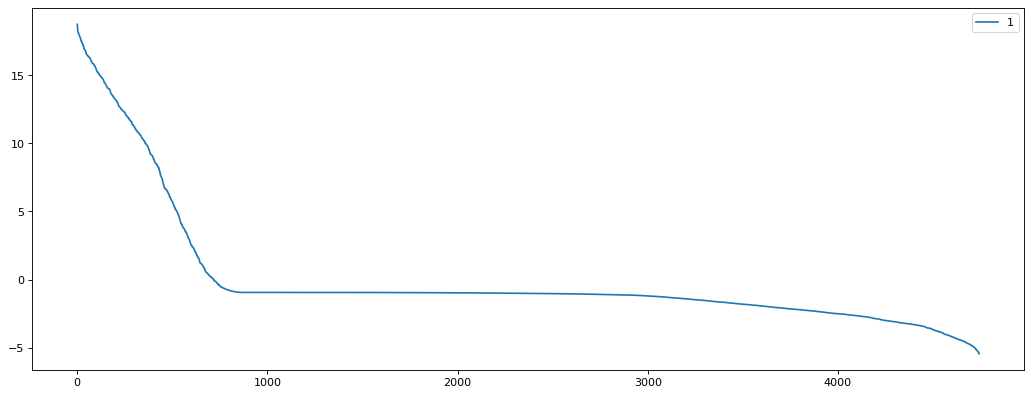

For this round, clique size= 578
Density for first 289 is 243.1349480968858 and for first 678 is 275.7286135693215
Plural set first calc: [  0.   0.   0. 577.   1.   0.]
Plural set after filtration: [  0.   0.   0. 463.   0.   0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 1
n1= 4280


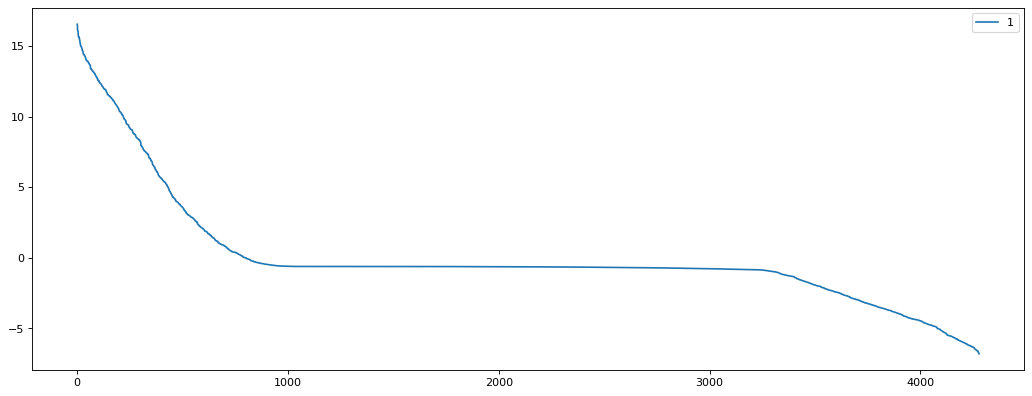

For this round, clique size= 461
Density for first 230 is 192.8608695652174 and for first 561 is 225.72192513368984
Plural set first calc: [460.   1.   0.   0.   0.   0.]
Plural set after filtration: [376.   0.   0.   0.   0.   0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 2
n1= 3904


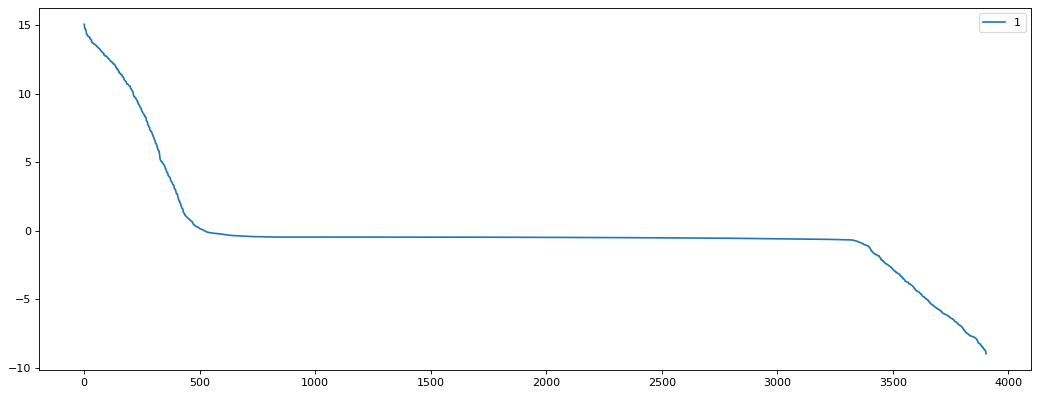

For this round, clique size= 428
Density for first 214 is 193.05607476635515 and for first 528 is 190.3598484848485
Plural set first calc: [  5. 421.   0.   0.   2.   0.]
Plural set after filtration: [  1. 324.   0.   0.   0.   0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 3
n1= 3579


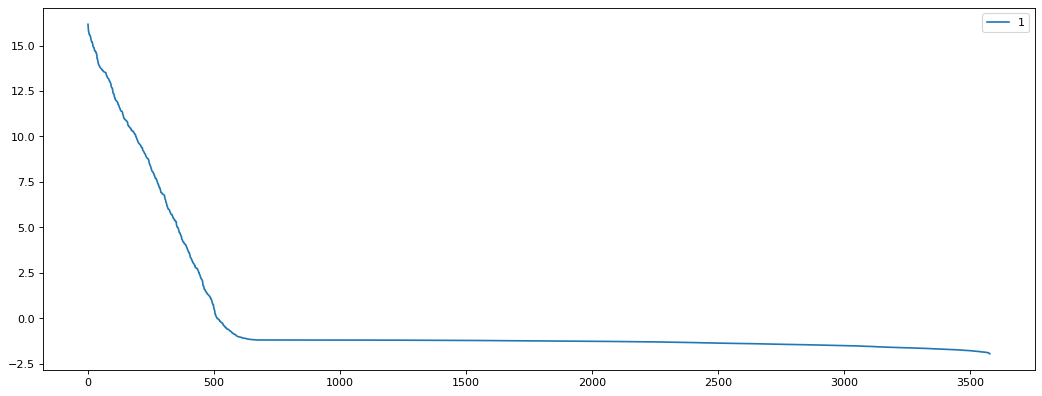

For this round, clique size= 410
Density for first 205 is 170.4780487804878 and for first 510 is 193.34509803921569
Plural set first calc: [  0.   0.   0.   0.   0. 410.]
Plural set after filtration: [  0.   0.   0.   0.   0. 331.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 4
n1= 3248


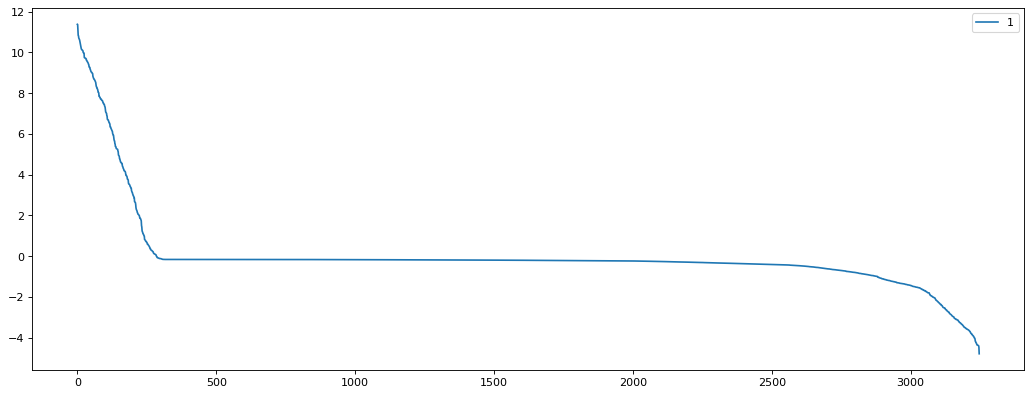

For this round, clique size= 209
Density for first 104 is 89.3076923076923 and for first 309 is 85.28155339805825
Plural set first calc: [  0.   0.   0. 197.  12.   0.]
Plural set after filtration: [  0.   0.   0. 160.   3.   0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 5
n1= 3085


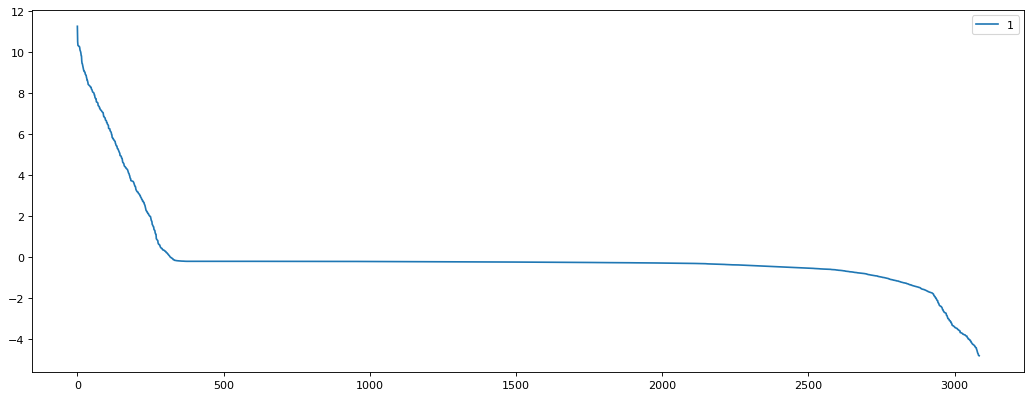

For this round, clique size= 198
Density for first 99 is 80.36363636363636 and for first 298 is 93.85234899328859
Plural set first calc: [  0.   0.   0.   0. 198.   0.]
Plural set after filtration: [  0.   0.   0.   0. 164.   0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 6
n1= 2921


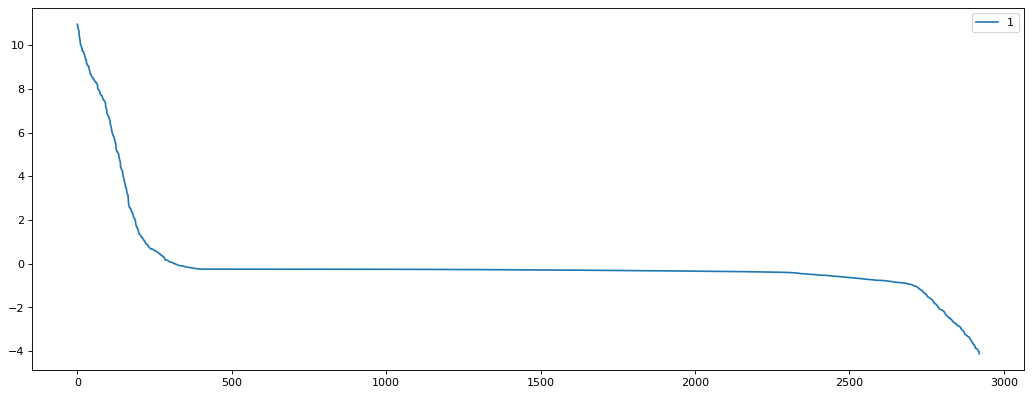

For this round, clique size= 188
Density for first 94 is 83.1063829787234 and for first 288 is 81.47222222222223
Plural set first calc: [187.   1.   0.   0.   0.   0.]
Plural set after filtration: [148.   0.   0.   0.   0.   0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 7
n1= 2773


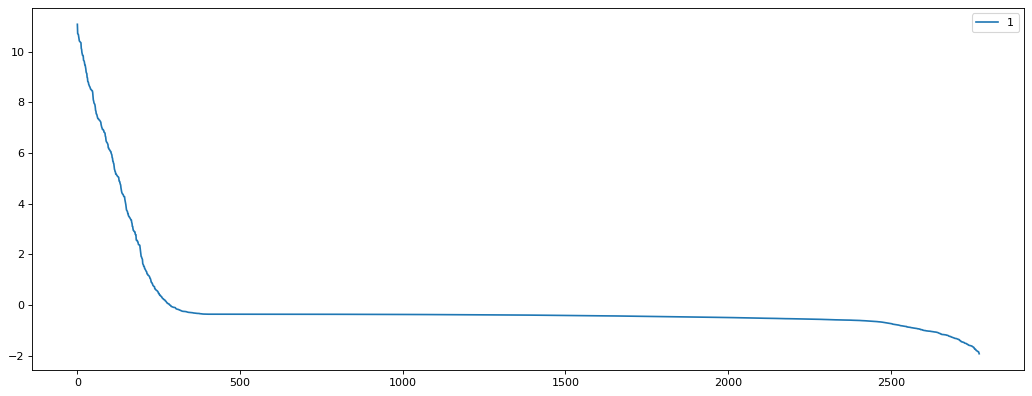

For this round, clique size= 176
Density for first 88 is 72.93181818181819 and for first 276 is 77.21739130434783
Plural set first calc: [175.   1.   0.   0.   0.   0.]
Plural set after filtration: [140.   0.   0.   0.   0.   0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 8
n1= 2633


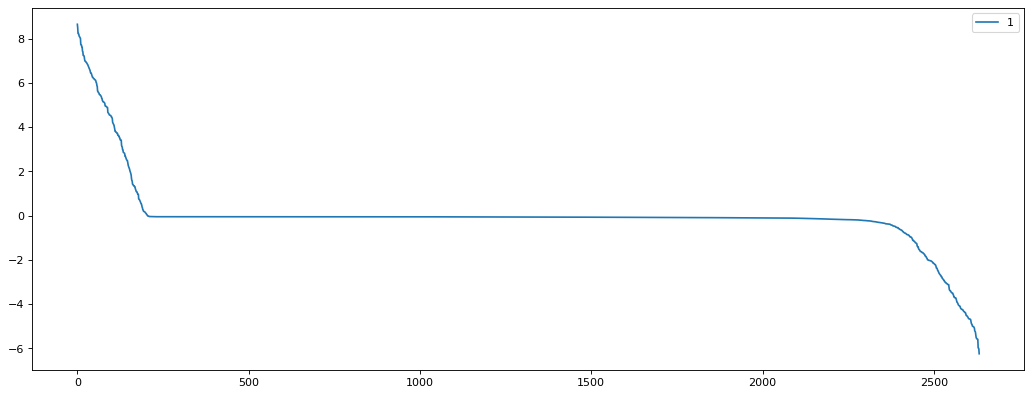

For this round, clique size= 149
Density for first 74 is 60.513513513513516 and for first 249 is 56.31325301204819
Plural set first calc: [  0.   0. 149.   0.   0.   0.]
Plural set after filtration: [  0.   0. 126.   0.   0.   0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 9
n1= 2507


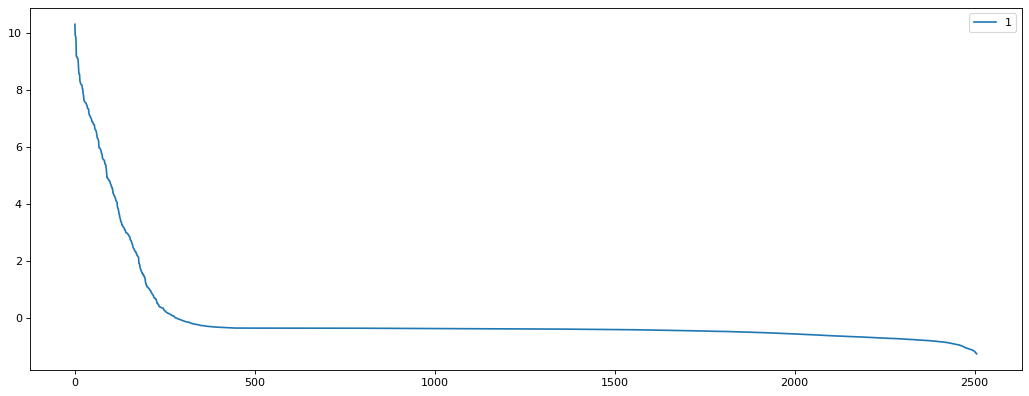

For this round, clique size= 142
Density for first 71 is 55.91549295774648 and for first 242 is 63.900826446280995
Plural set first calc: [  0. 142.   0.   0.   0.   0.]
Plural set after filtration: [  0. 119.   0.   0.   0.   0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 10
n1= 2388


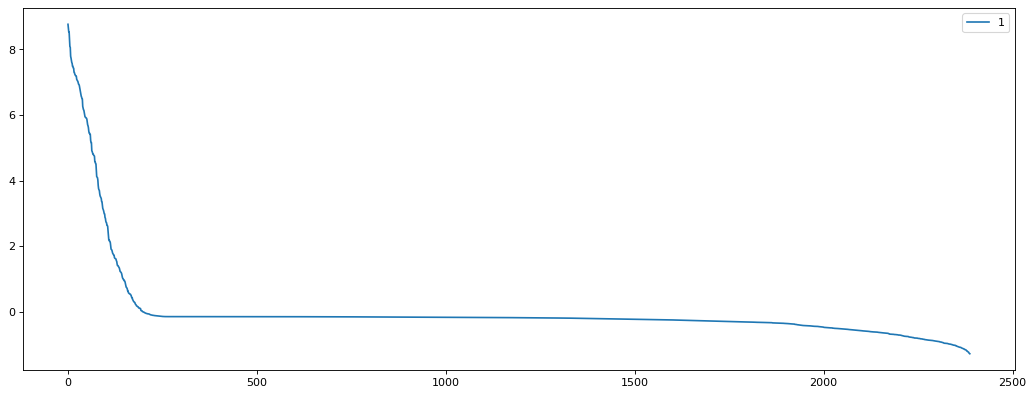

For this round, clique size= 112
Density for first 56 is 47.0 and for first 212 is 42.509433962264154
Plural set first calc: [112.   0.   0.   0.   0.   0.]
Plural set after filtration: [82.  0.  0.  0.  0.  0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 11
n1= 2306


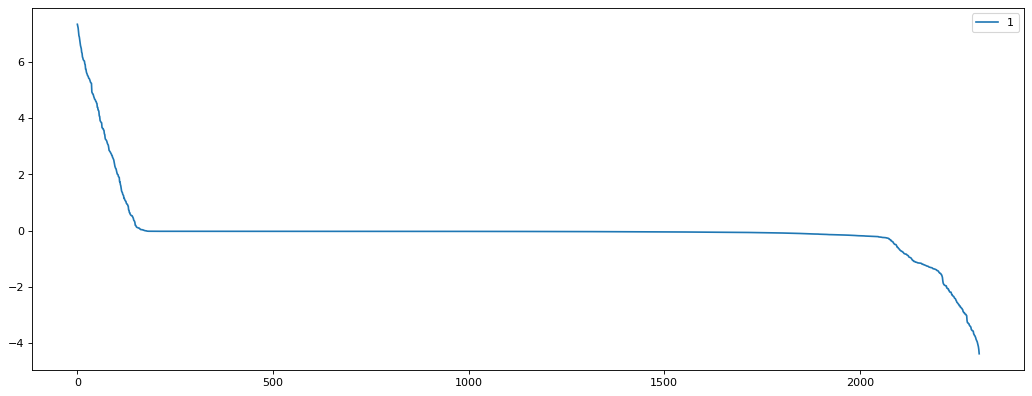

For this round, clique size= 100
Density for first 50 is 40.84 and for first 200 is 35.1
Plural set first calc: [  0.   0.   0. 100.   0.   0.]
Plural set after filtration: [ 0.  0.  0. 79.  0.  0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 12
n1= 2227


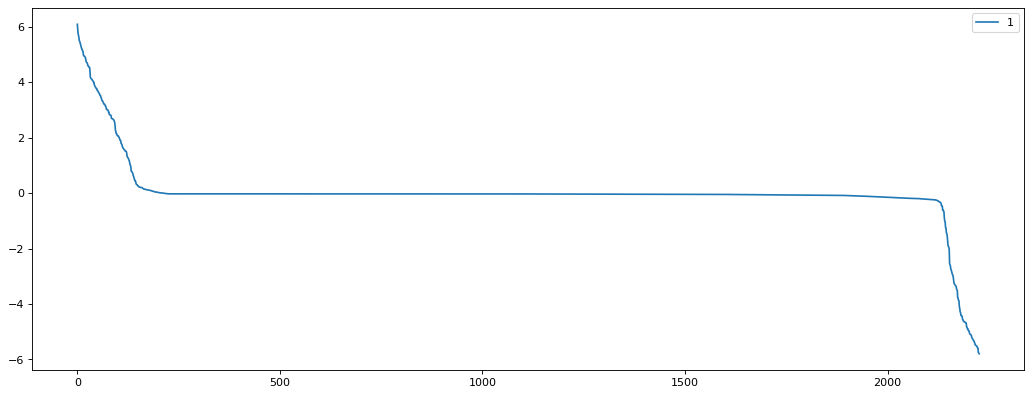

For this round, clique size= 101
Density for first 50 is 38.6 and for first 201 is 41.582089552238806
Plural set first calc: [  0.   0.   0.   0.   1. 100.]
Plural set after filtration: [ 0.  0.  0.  0.  1. 90.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 13
n1= 2136


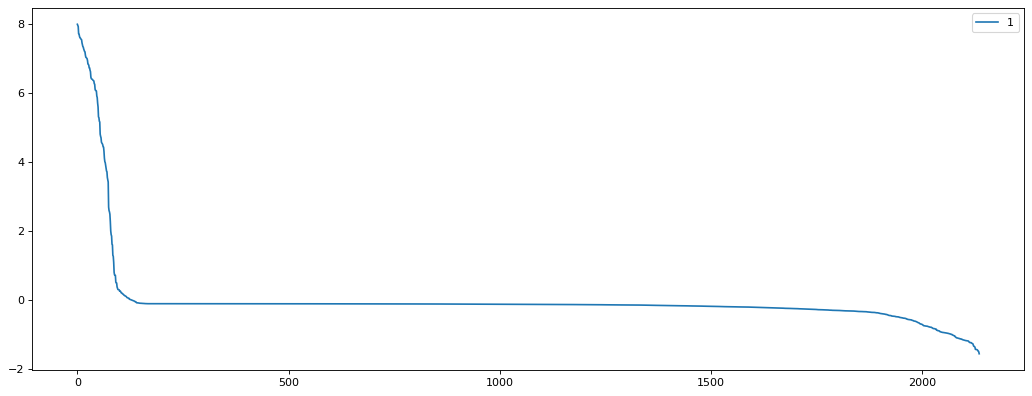

For this round, clique size= 97
Density for first 48 is 45.375 and for first 197 is 27.746192893401016
Plural set first calc: [ 0.  0.  0.  0. 97.  0.]
Plural set after filtration: [ 0.  0.  0.  0. 74.  0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 14
n1= 2062


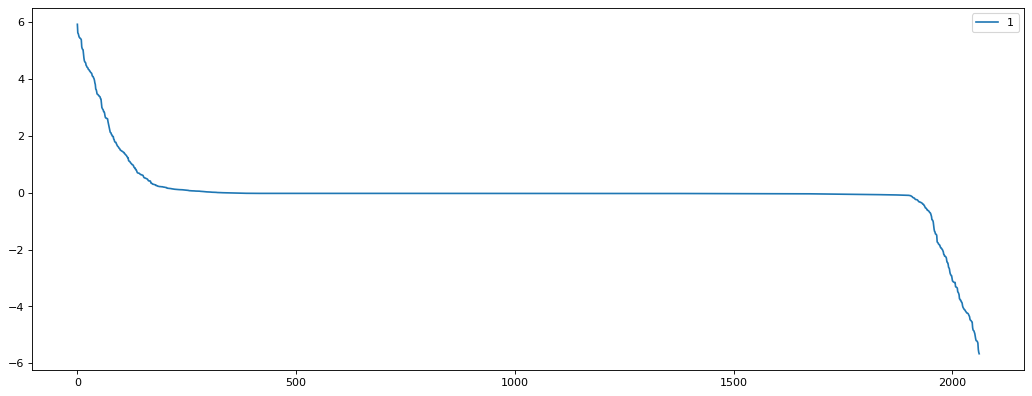

For this round, clique size= 90
Density for first 45 is 37.51111111111111 and for first 190 is 38.55789473684211
Plural set first calc: [ 0.  0.  0.  0.  1. 89.]
Plural set after filtration: [ 0.  0.  0.  0.  0. 70.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 15
n1= 1992


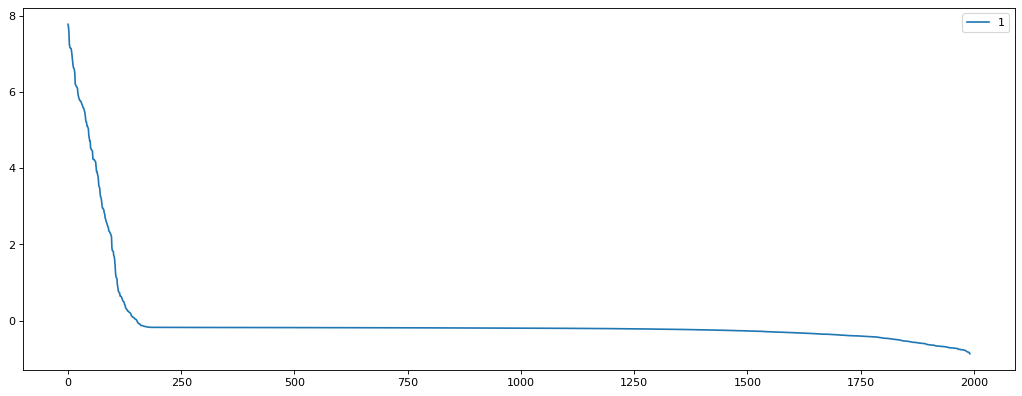

For this round, clique size= 91
Density for first 45 is 37.111111111111114 and for first 191 is 33.81151832460733
Plural set first calc: [ 0.  0.  0.  0. 91.  0.]
Plural set after filtration: [ 0.  0.  0.  0. 73.  0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 16
n1= 1919


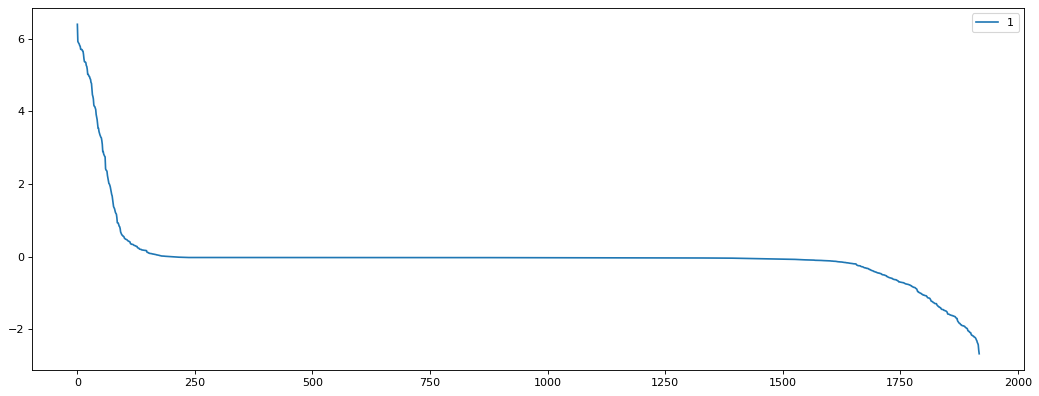

For this round, clique size= 76
Density for first 38 is 32.421052631578945 and for first 176 is 28.068181818181817
Plural set first calc: [ 2. 73.  0.  0.  1.  0.]
Plural set after filtration: [ 0. 61.  0.  0.  0.  0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 17
n1= 1858


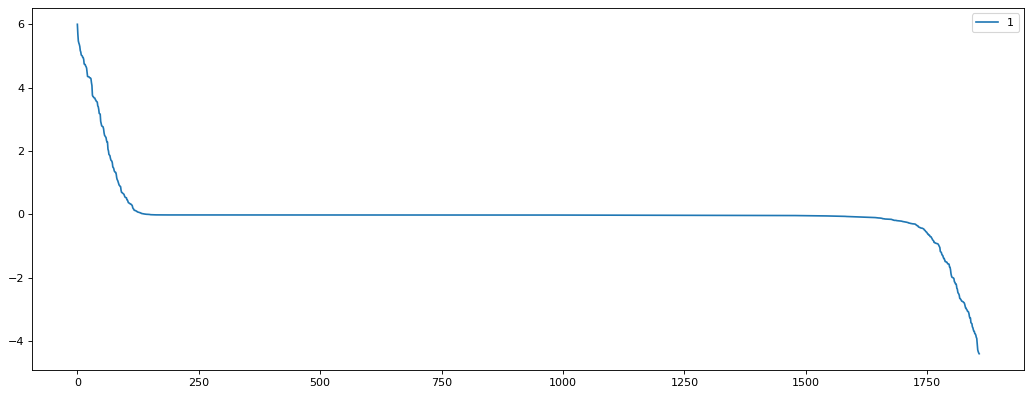

For this round, clique size= 74
Density for first 37 is 30.594594594594593 and for first 174 is 23.988505747126435
Plural set first calc: [ 0. 73.  0.  0.  1.  0.]
Plural set after filtration: [ 0. 57.  0.  0.  0.  0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 18
n1= 1801


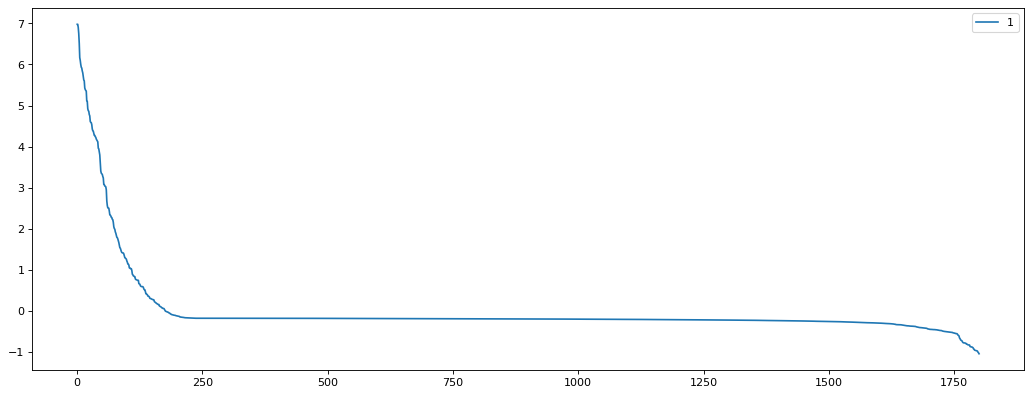

For this round, clique size= 72
Density for first 36 is 28.555555555555557 and for first 172 is 31.848837209302324
Plural set first calc: [ 0. 72.  0.  0.  0.  0.]
Plural set after filtration: [ 0. 56.  0.  0.  0.  0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 19
n1= 1745


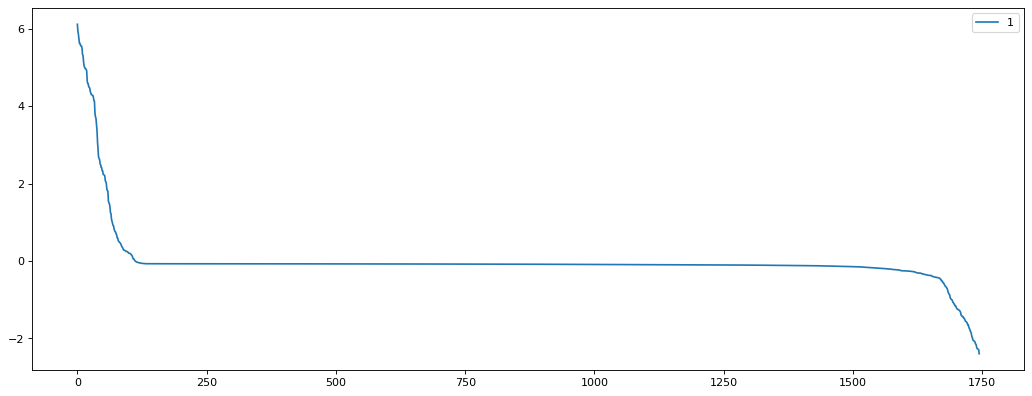

For this round, clique size= 61
Density for first 30 is 26.2 and for first 161 is 19.86335403726708
Plural set first calc: [ 0.  0.  0. 59.  2.  0.]
Plural set after filtration: [ 0.  0.  0. 46.  0.  0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 20
n1= 1699


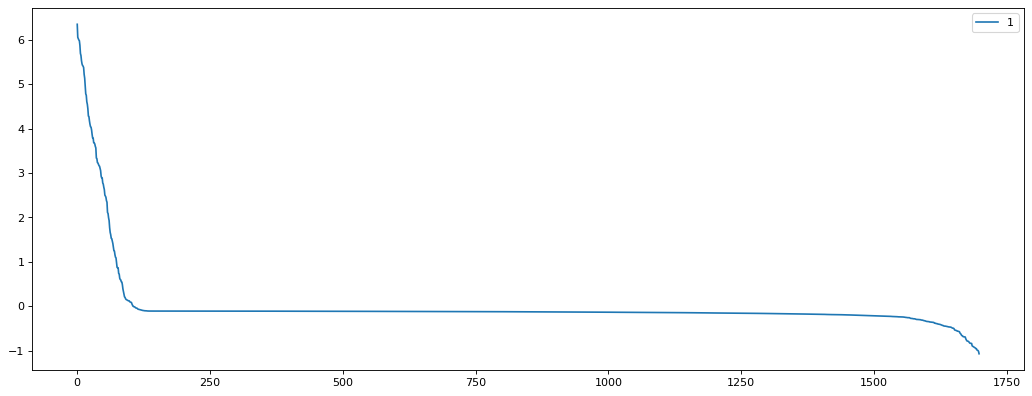

For this round, clique size= 62
Density for first 31 is 24.387096774193548 and for first 162 is 17.02469135802469
Plural set first calc: [ 0.  0.  0.  0.  0. 62.]
Plural set after filtration: [ 0.  0.  0.  0.  0. 52.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 21
n1= 1647


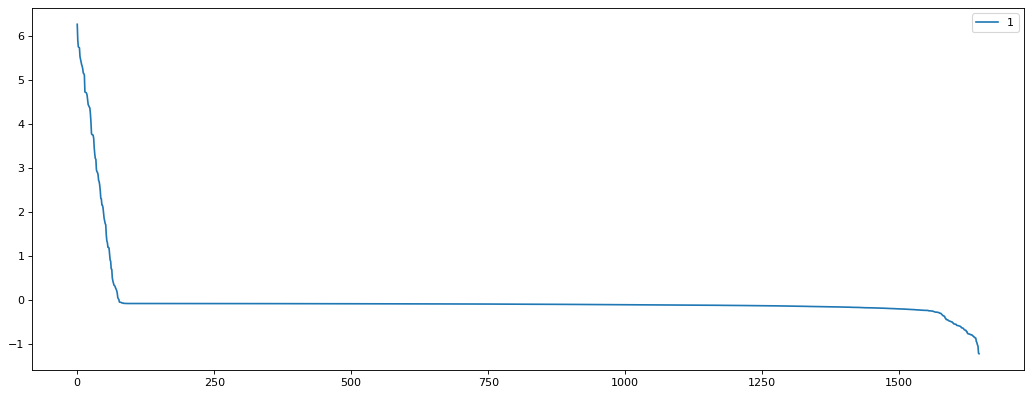

For this round, clique size= 57
Density for first 28 is 23.928571428571427 and for first 157 is 12.21656050955414
Plural set first calc: [ 0.  0. 57.  0.  0.  0.]
Plural set after filtration: [ 0.  0. 44.  0.  0.  0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 22
n1= 1603


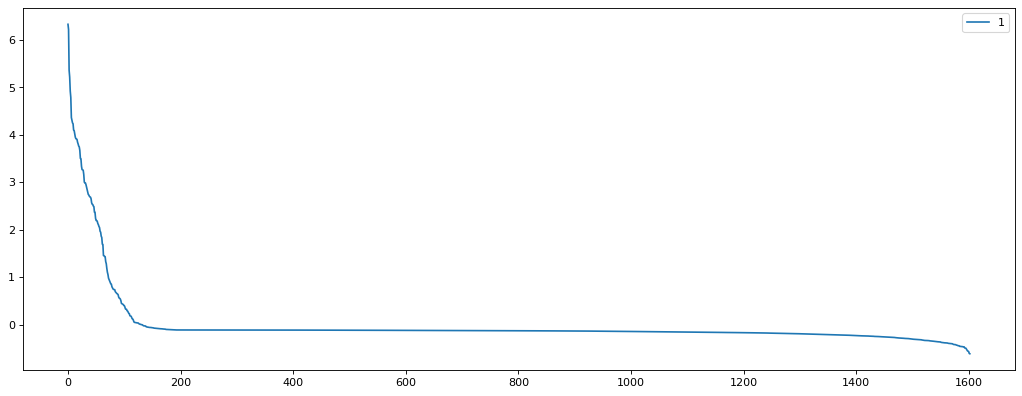

For this round, clique size= 46
Density for first 23 is 17.130434782608695 and for first 146 is 17.876712328767123
Plural set first calc: [ 0. 46.  0.  0.  0.  0.]
Plural set after filtration: [ 0. 42.  0.  0.  0.  0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 23
n1= 1561


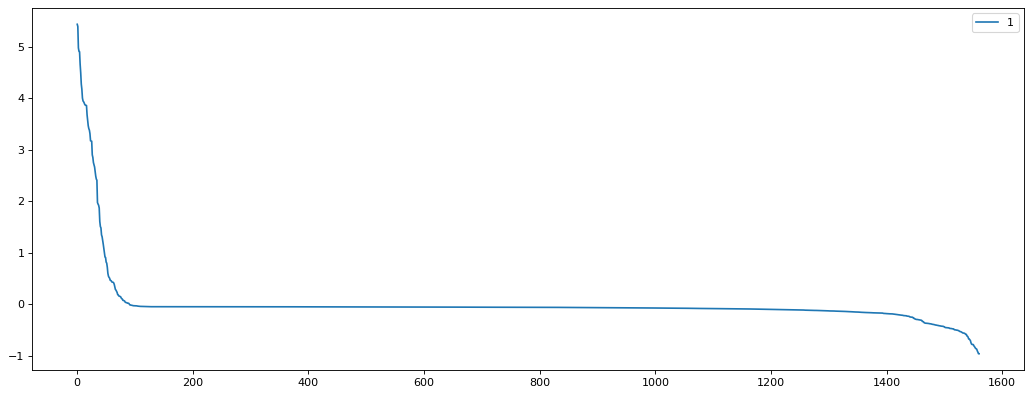

For this round, clique size= 43
Density for first 21 is 17.238095238095237 and for first 143 is 11.776223776223777
Plural set first calc: [43.  0.  0.  0.  0.  0.]
Plural set after filtration: [35.  0.  0.  0.  0.  0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 24
n1= 1526


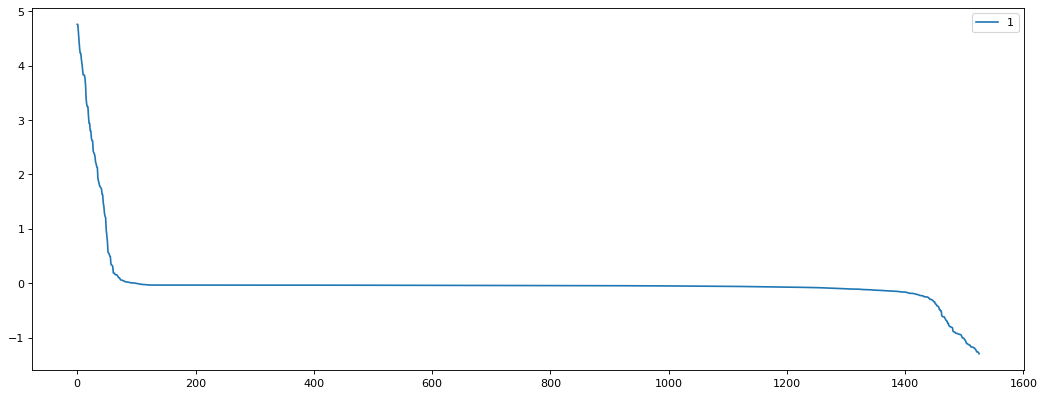

For this round, clique size= 42
Density for first 21 is 16.761904761904763 and for first 142 is 14.253521126760564
Plural set first calc: [42.  0.  0.  0.  0.  0.]
Plural set after filtration: [36.  0.  0.  0.  0.  0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 25
n1= 1490


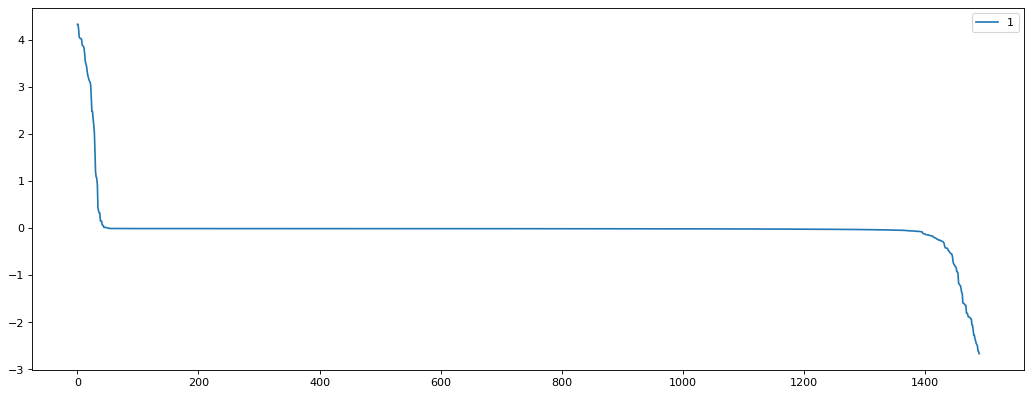

For this round, clique size= 38
Density for first 19 is 17.263157894736842 and for first 138 is 6.318840579710145
Plural set first calc: [ 0.  0.  0. 38.  0.  0.]
Plural set after filtration: [ 0.  0.  0. 30.  0.  0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 26
n1= 1460


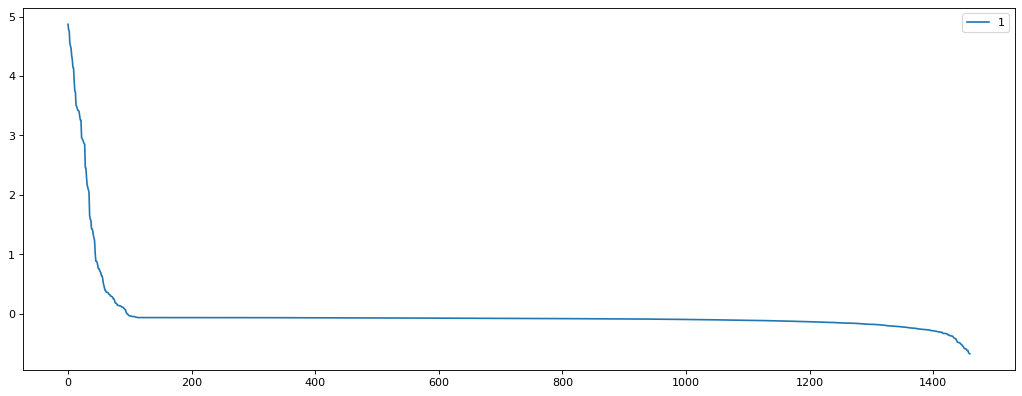

For this round, clique size= 40
Density for first 20 is 16.4 and for first 140 is 12.971428571428572
Plural set first calc: [ 0.  0.  0.  0. 40.  0.]
Plural set after filtration: [ 0.  0.  0.  0. 33.  0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 27
n1= 1427


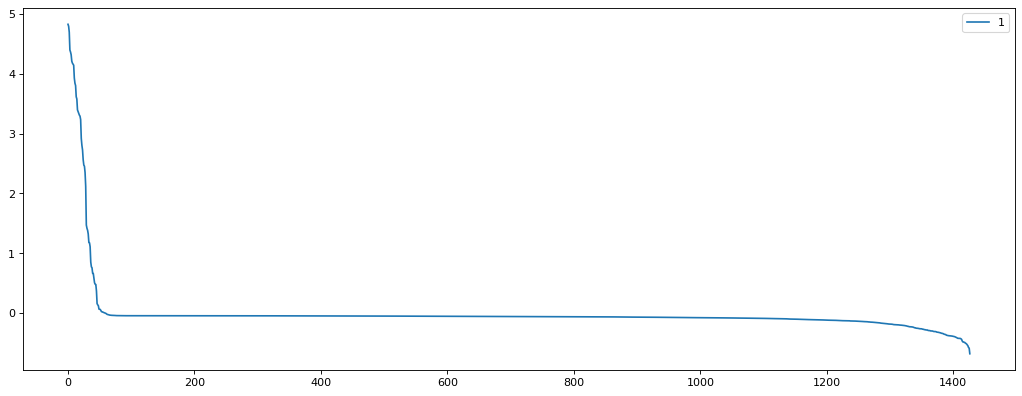

For this round, clique size= 34
Density for first 17 is 14.588235294117647 and for first 134 is 7.1940298507462686
Plural set first calc: [ 0.  0.  0.  0.  0. 34.]
Plural set after filtration: [ 0.  0.  0.  0.  0. 27.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 28
n1= 1400


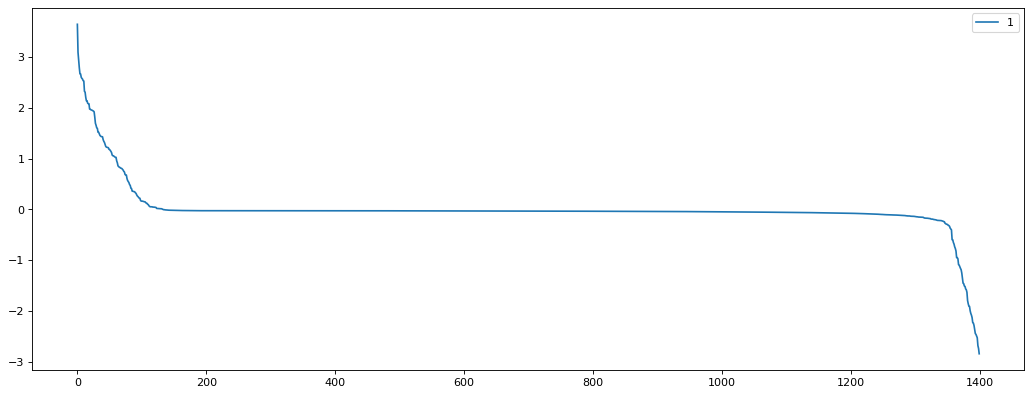

For this round, clique size= 28
Density for first 14 is 8.714285714285714 and for first 128 is 13.40625
Plural set first calc: [ 0. 28.  0.  0.  0.  0.]
Plural set after filtration: [ 0. 25.  0.  0.  0.  0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 29
n1= 1375


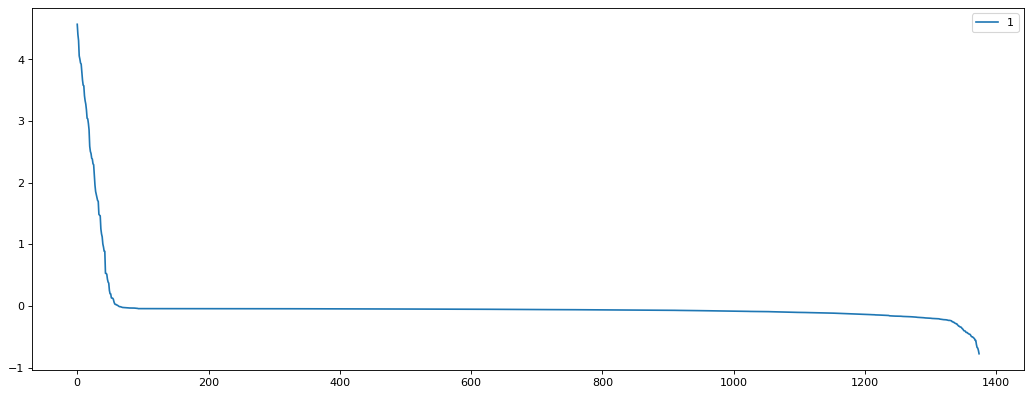

For this round, clique size= 33
Density for first 16 is 13.25 and for first 133 is 8.646616541353383
Plural set first calc: [ 0.  0.  0.  0. 33.  0.]
Plural set after filtration: [ 0.  0.  0.  0. 28.  0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 30
n1= 1347


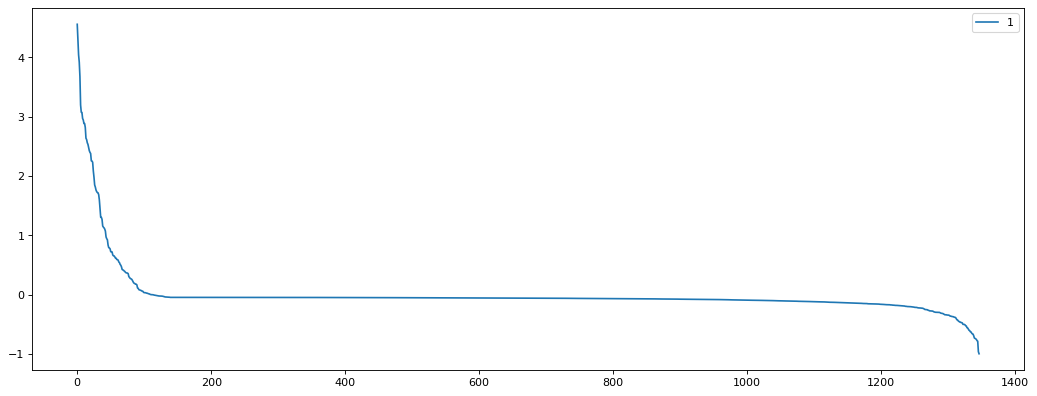

For this round, clique size= 31
Density for first 15 is 10.933333333333334 and for first 131 is 11.48091603053435
Plural set first calc: [31.  0.  0.  0.  0.  0.]
Plural set after filtration: [26.  0.  0.  0.  0.  0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 31
n1= 1321


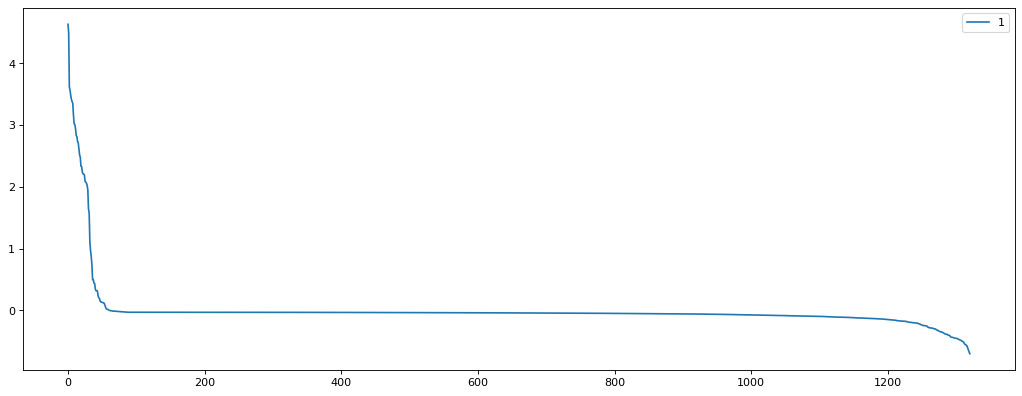

For this round, clique size= 32
Density for first 16 is 11.375 and for first 132 is 6.606060606060606
Plural set first calc: [ 0.  0.  0.  0. 32.  0.]
Plural set after filtration: [ 0.  0.  0.  0. 29.  0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 32
n1= 1292


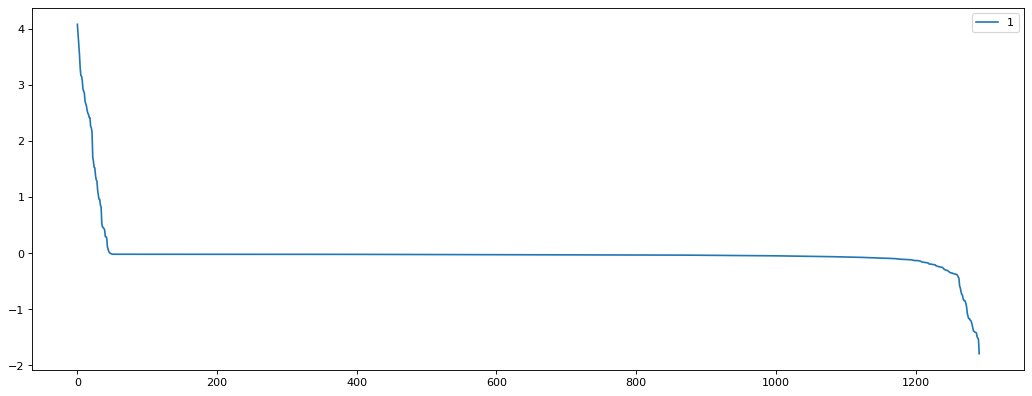

For this round, clique size= 30
Density for first 15 is 11.2 and for first 130 is 4.507692307692308
Plural set first calc: [ 0.  0.  0.  0. 30.  0.]
Plural set after filtration: [ 0.  0.  0.  0. 23.  0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 33
n1= 1269


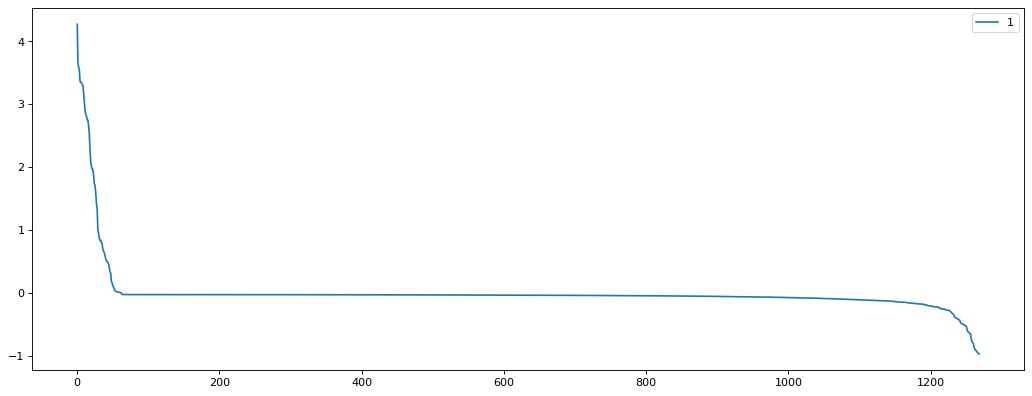

For this round, clique size= 30
Density for first 15 is 11.6 and for first 130 is 5.323076923076923
Plural set first calc: [ 0.  0.  0. 30.  0.  0.]
Plural set after filtration: [ 0.  0.  0. 25.  0.  0.]
Firstiden for this cluster is:
Recovery step
Creating Virtual Cluster 34
n1= 1244


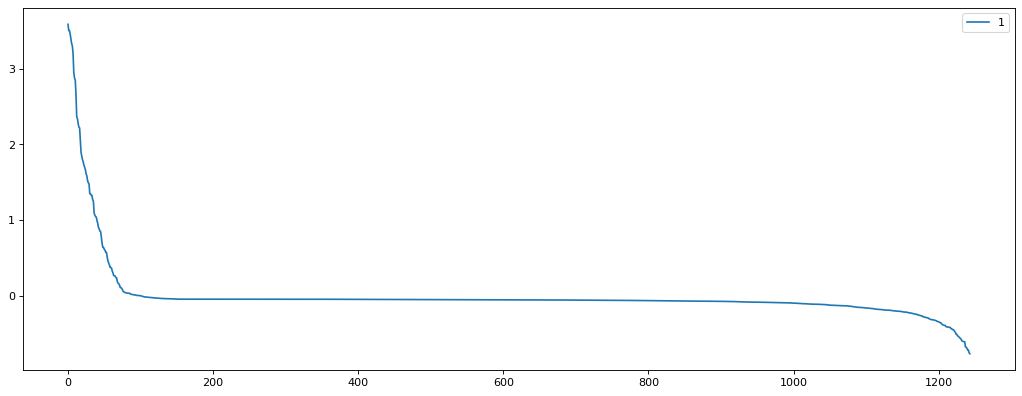

For this round, clique size= 26
Density for first 13 is 9.846153846153847 and for first 126 is 9.80952380952381
Plural set first calc: [ 0. 26.  0.  0.  0.  0.]
Plural set after filtration: [ 0. 20.  0.  0.  0.  0.]
Firstiden for this cluster is:
Recovery step
We have finished with 35 many clusters and  1244 many unassigned cells


In [24]:
#New-approach-only-plural-and-merge

firstiden=[]

ll1=n*(n-1)//2
ty=np.shape(scomp)
ll2=ty[0]

t1=0
pcn=0
per=0.03
lp=n1

stopper=per*1000*2//3
print("Stopper for this case=",stopper)

while(lp>stopper):

    print("Creating Virtual Cluster",current)
    
    n1,nadj,nadj1,cur,rcur,gU,tdeg=makegraph(sol,iden,n,per,scomp)

     

    sproj=pluralset(nadj1,n1,pcn,gU)

    printer=np.zeros(n1)
    for i in range(n1):
        printer[i]=sproj[i][0]
        
    printplot(printer,n1)

    

    checker=[]
    checkt=[]
    checktt=[]

    if(n1//2>2000):
        st=2000
    else:
        st=n1//2


    

    for jjj in range(st):
        checker.append(sproj[jjj][1])
    
    
    #if(current==0):
    #    printplotsave(printer,checker,nadj,n1)



    

    l=10
    r=st    
    while(l<r):
        mid=(l+r)//2
        checker1=checker[0:mid]
        avg1=degrees1(checker1,n1,nadj)

        

        #changing from //2 to //1.5
        if(avg1>mid//2):
            l=mid+1

        else:
            r=mid-1



    print("For this round, clique size=",mid) 
    checker1=checker[0:mid//2]
    avg1=degrees1(checker1,n1,nadj)
    mid1=mid+100
    checker2=checker[0:mid1]
    avg2=degrees1(checker2,n1,nadj)

    print("Density for first",mid//2,"is",avg1,"and for first",mid+100,"is",avg2)

    
    cutoff=mid
    
    track1=[]
    for i in range(cutoff):
        t11=sproj[i][1]
        track1.append(t11)
        
    pcount=clusterid(track1,cur)
    print("Plural set first calc:",pcount)
    
    rset=filterset(track1,nadj,n1)
    degcount=clusterid(rset,cur)
        
    print("Plural set after filtration:",degcount)
    lp=len(rset)

    pos=majorityid(rset,cur)
    firstiden.append(pos)
    print("Firstiden for this cluster is:",)

    current=recovernew(rset,n1,sol,current,cur)

print("We have finished with",current,"many clusters and ",n1,"many unassigned cells") 

In [26]:
#create the lists

def clusterify(sol):

    preiden=[]
    remain=[]
    for i in range(current):
         preiden.append([])


    for i in range(n):
        if(sol[i]!=-1):
            t=round(sol[i])
            preiden[t].append(i)
        else:
            remain.append(i)

    return preiden,remain

In [27]:
#Storing confident sets separately. 
confset,remain=clusterify(sol)

In [28]:
print(len(confset))

35


In [30]:
#We start embedding using Louvain from here. 
print(len(confset))
cc=0

initial_cluster=np.zeros((n))

for i in range(current):
    for j in range(len(confset[i])):
        cc=cc+1
        t=round(j)
        t1=round(confset[i][t])
        initial_cluster[t1]=i

for i in range(len(remain)):
    cc=cc+1
    t1==round(remain[i])
    initial_cluster[t1]=current+i

print("The numeber of vertices marked=",cc,"number of clusters=",current+i)






35
The numeber of vertices marked= 4743 number of clusters= 1258


In [31]:
data = pd.read_csv("snn.csv", encoding= 'unicode_escape')
l=data.shape
print(l)
Adj=data.to_numpy()
print(np.shape(Adj))
G = nx.from_numpy_matrix(Adj)

(4743, 4743)
(4743, 4743)


12


In [34]:
def seuratcluster(seurat):

    l1=len(seurat)
    mx=0
    for i in range(l1):
        if(seurat[i]>mx):
            mx=seurat[i]

    l2=mx+1


    seuratiden=[]
    for i in range(l2):
        seuratiden.append([])

    for i in range(l1):
        t=round(seurat[i])
        seuratiden[t].append(i)

    return seuratiden

In [35]:
def cluster(preiden,iden):

    l=len(preiden)

    for i in range(l):
        t=len(preiden[i])
    
        degcount=np.zeros((cln))

        for j in range(t):
            t=round(preiden[i][j])
            t1=round(iden[t])
            degcount[t1]=degcount[t1]+1

        
        print(degcount.astype(int))

In [45]:
# compute the best leveled cluster
l_cluster = best_leveled_cluster(G, initial_cluster,resolution=0.5)
loutput=[]
for i in range(n):
    loutput.append(l_cluster[i])


print(max(loutput))

9


In [46]:
print(len(loutput))

louvainiden=seuratcluster(loutput)
cluster(louvainiden,iden)


4743
[368   9   3   0   0   1]
[  0   2   0   0   2 724]
[  0   0   0   0 414   0]
[645   2   0   0   0   0]
[  3   1  26 652 171   4]
[  4 417   0   1   0  13]
[  0   0   3 302  17   0]
[  0   0 228   0   1   0]
[  2   0   0   0 231   0]
[  0 493   0   0   3   1]


In [48]:
#Pre-merging step
#We also have firsiden

firstidenstore=firstiden

sol1=sol
current0=current
print(firstidenstore,firstiden)


[3, 0, 1, 5, 3, 4, 0, 0, 2, 1, 0, 3, 5, 4, 5, 4, 1, 1, 1, 3, 5, 2, 1, 0, 0, 3, 4, 5, 1, 4, 0, 4, 4, 3, 1] [3, 0, 1, 5, 3, 4, 0, 0, 2, 1, 0, 3, 5, 4, 5, 4, 1, 1, 1, 3, 5, 2, 1, 0, 0, 3, 4, 5, 1, 4, 0, 4, 4, 3, 1]


In [86]:
firstiden=firstidenstore

In [87]:
for i in range(current):
    if((firstiden[i]==4 and len(confset[i])==31) or (firstiden[i]==2 and len(confset[i])==14)):
        
        for j in range(len(confset[i])):
            print(confset[i][j]+1,",",end='')

In [47]:
#Makeset

ty=np.shape(scomp)
ll=ty[0]
#ll=(n*(n-1))//2
k=round(0.015*n)


print(k)

extractor=np.zeros((n,k))

for i in range(n):
    for j in range(k):
        extractor[i][j]=-1

counter=np.zeros((n))


for i in range(ll):
    x=round(scomp[i][3])
    y=round(scomp[i][4])

    if(counter[x]<k-1):
        xx=round(counter[x])
        extractor[x][xx]=y
        counter[x]=counter[x]+1

    if(counter[y]<k-1):
        yy=round(counter[y])
        extractor[y][yy]=x
        counter[y]=counter[y]+1

71


In [50]:
#Pairwise symmetric based merging
current=current0
firstiden=[]
for i in range(current):
    firstiden.append(firstidenstore[i])

firstiden1=firstiden
print(current,firstiden,firstidenstore,len(firstiden),len(firstiden1),len(firstidenstore))

stopp=0
sol1=sol
current1=current
preiden,remain=clusterify(sol)
print(len(preiden))

zscore=[]

cnum=9

print("current=",current,"cc=",cnum)

for l in range(current-cnum):

    score=np.zeros((current1,current1,3))
    score1=np.zeros((current1,current1,3))

   
    for i in range(current1):
        for j in range(current1):
            co=0
            for i1 in range(len(preiden[i])):
                t1=round(preiden[i][i1])
                temp=set(extractor[t1,:])
                temp1=set(preiden[j])
                temp2=temp.intersection(temp1)

                co=co+len(temp2)


            co=co/len(preiden[i])
            score[i][j][0]=co
            score[i][j][1]=firstiden1[i]
            score[i][j][2]=firstiden1[j]
                


    for i in range(current1):
        for j in range(current1):
            score1[i][j][0]=score[i][j][0]*score[j][i][0]
            score1[i][j][1]= score[i][j][1]
            score1[i][j][2]= score[i][j][2]

    ss=current1*current1
    mergable=np.zeros((ss,5))

    t=0
    for i in range(current1):
        for j in range(current1):
                if(i!=j):
                    mergable[t][0]=score1[i][j][0]
                    mergable[t][1]=score1[i][j][1]
                    mergable[t][2]=score1[i][j][2]
                    mergable[t][3]=i 
                    mergable[t][4]=j
                
                t=t+1

    smerge=sorted(mergable, key=operator.itemgetter(0), reverse=True)

    print("Merge candidate",smerge[0])

    zscore.append(smerge[0][0])

    current1=current1-1
    m1=round(smerge[0][3])
    m2=round(smerge[0][4])

    print("The merge is between clusters",m1,m2,"With identities",smerge[0][1],smerge[0][2],"of size",len(preiden[m1]),len(preiden[m2]))

    #print("print some more values")
    #for tt in range(current1):
    #    print(smerge[tt])

    new1=preiden[m1]+preiden[m2]
    pos1=firstiden[m1]


    index=[m1,m2]
    preiden = [e for i, e in enumerate(preiden) if i not in index]
    firstiden = [e for i, e in enumerate(firstiden) if i not in index]

    #preiden.pop(m1,m2)
    #preiden.pop(m2)
    #firstiden.pop(m1,m2)
    #firstiden.pop(m2)

    preiden1=[]
    for i in range(current1):
         preiden1.append([])

    
    firstiden1=[]

    preiden1[0]=new1
    firstiden1.append(pos1)
    

    print(len(firstiden1),len(firstiden))
      
    for i in range(1,current1):
        preiden1[i]=preiden[i-1]
        firstiden1.append(firstiden[i-1])

    

    preiden=preiden1
    firstiden=firstiden1

    print("Going for the next merge")


print("Finsihed merging with",len(preiden),"many confident clusters")


35 [3, 0, 1, 5, 3, 4, 0, 0, 2, 1, 0, 3, 5, 4, 5, 4, 1, 1, 1, 3, 5, 2, 1, 0, 0, 3, 4, 5, 1, 4, 0, 4, 4, 3, 1] [3, 0, 1, 5, 3, 4, 0, 0, 2, 1, 0, 3, 5, 4, 5, 4, 1, 1, 1, 3, 5, 2, 1, 0, 0, 3, 4, 5, 1, 4, 0, 4, 4, 3, 1] 35 35 35
35
current= 35 cc= 9
Merge candidate [167.19202899   3.           3.          19.          25.        ]
The merge is between clusters 19 25 With identities 3.0 3.0 of size 46 30
1 33
Going for the next merge
Merge candidate [161.29600953   4.           4.          16.          31.        ]
The merge is between clusters 16 31 With identities 4.0 4.0 of size 73 23
1 32
Going for the next merge
Merge candidate [104.48253968   5.           5.          16.          26.        ]
The merge is between clusters 16 26 With identities 5.0 5.0 of size 70 27
1 31
Going for the next merge
Merge candidate [99.72638889  0.          0.         10.         24.        ]
The merge is between clusters 10 24 With identities 0.0 0.0 of size 140 36
1 30
Going for the next merge
Merge candi

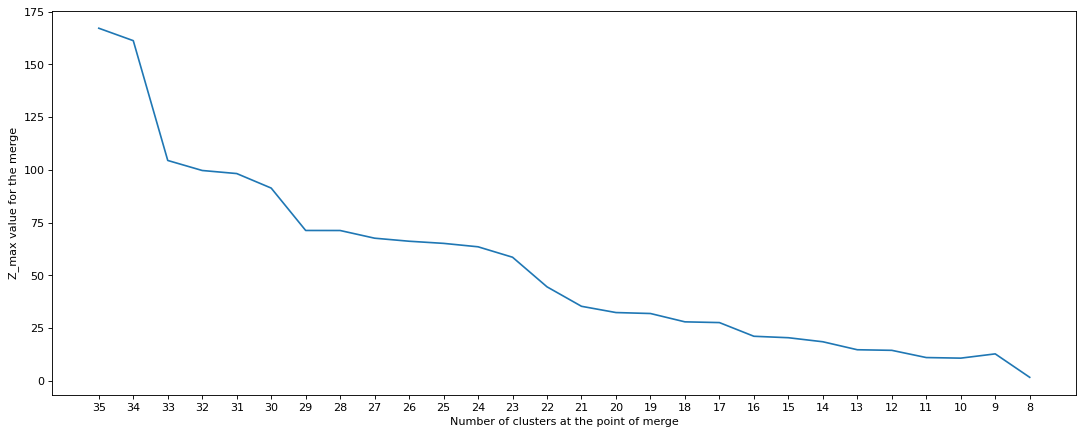

In [100]:
y=[]
y1=[]
for i in range(len(zscore)):
    y1.append(current-i)
    y.append(i)




fig = plt.figure(figsize=(16, 6), dpi=80)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xticks(y)
ax.set_xticklabels(y1)

plt.xlabel("Number of clusters at the point of merge")
plt.ylabel("Z_max value for the merge")
plt.plot(zscore)
plt.savefig("zmax.png")
plt.show()    


In [52]:
#storing confident clusters

l2=len(preiden)

confcluster=[]
for i in range(l2):
    confcluster.append(preiden[i])



In [51]:
print(len(preiden))

9


In [56]:
print(len(preiden))
cc=0

initial_cluster=np.zeros((n))

for i in range(len(preiden)):
    for j in range(len(preiden[i])):
        cc=cc+1
        t=round(j)
        t1=round(preiden[i][t])
        initial_cluster[t1]=i

for i in range(len(remain)):
    cc=cc+1
    t1==round(remain[i])
    initial_cluster[t1]=len(preiden)+i

print("The numeber of vertices marked=",cc,"number of clusters=",len(preiden)+i)


9
The numeber of vertices marked= 4743 number of clusters= 1232


In [60]:
l_cluster = best_leveled_cluster(G, initial_cluster,resolution=2)
loutput=[]
for i in range(n):
    loutput.append(l_cluster[i])


print(max(loutput))

8


In [61]:
print(len(loutput))

louvainiden=seuratcluster(loutput)
cluster(louvainiden,iden)

4743
[1001    6    3    0    0    0]
[  3 481  25   0 154   5]
[  2 307   0   1   0   9]
[ 14 129   0   1   0  10]
[  2   0   0   0 234   0]
[  0   1   0   0   2 719]
[  0   0   3 953  30   0]
[  0   0 229   0   5   0]
[  0   0   0   0 414   0]


In [103]:
#Symmetric Merging.


print(cnum,cln)

for i in range(cnum):
    t=len(preiden[i])
    degcount=np.zeros((cln))

    for j in range(t):
        t=round(preiden[i][j])
        t1=round(iden[t])
        degcount[t1]=degcount[t1]+1

    print(degcount)

7 6
[  1. 704.   0.   0.   0.   0.]
[  0.   0.   0.   0. 295.   0.]
[  0.   0.   0. 803.   3.   0.]
[  0.   0.   0.   0.   1. 570.]
[843.   0.   0.   0.   0.   0.]
[  0.   0.   0.   0. 129.   0.]
[  0.   0. 170.   0.   0.   0.]


In [94]:
cluster(confcluster,iden)

[844 704   0   0   0   0]
[  0   0   0   0 295   0]
[  0   0   0 803   3   0]
[  0   0   0   0   1 570]
[  0   0   0   0 129   0]
[  0   0 170   0   0   0]


In [95]:
#Majority vote
print(k)

ch=1
lold=0
while(ch!=0):

    unmatched=np.zeros((n))
    for i in range(n):
        unmatched[i]=-1


    preiden1=[]
    for i in range(cnum):
            preiden1.append([])

    for i in range(cnum):
        for j in range(len(preiden[i])):
            t=preiden[i][j]
            unmatched[t]=0

    remain=[]
    for i in range(n):
        if(unmatched[i]==-1):
            remain.append(i)

    print("Remaining vertices=",len(remain))






    for i in range(cnum):
        temp1=set(preiden[i])
        for j in range(len(remain)):
            t1=round(remain[j])
            temp2=set(extractor[t1,:])

            temp3=temp1.intersection(temp2)

            l1=len(temp3)

            if(l1>k//2):
                preiden1[i].append(t1)

    for i in range(cnum):
        preiden[i]=preiden[i]+preiden1[i] 
        

    for i in range(cnum):
        t=len(preiden[i])
        degcount=np.zeros((cln))

        for j in range(t):
            t=round(preiden[i][j])
            t1=round(iden[t])
            degcount[t1]=degcount[t1]+1

        print(degcount.astype(int))

    
    if(len(remain)==lold):
        ch=0

    lold=len(remain)





71
Remaining vertices= 1224
[1003  868    2    1    3    6]
[  0   0   0   0 378   0]
[  0   0   1 949  30   1]
[  0   1   0   0   2 719]
[  1   0   0   0 167   0]
[  0   0 214   0   1   0]
Remaining vertices= 396
[1015  902    2    1    3    8]
[  0   0   0   0 427   1]
[  0   0   2 951  31   1]
[  0   3   0   0   2 731]
[  1   0   0   0 187   0]
[  0   0 220   0   3   0]
Remaining vertices= 252
[1016  912    2    1    3    8]
[  2   0   1   0 447   1]
[  0   0   2 951  31   1]
[  0   5   0   0   2 732]
[  1   0   0   0 195   0]
[  0   0 222   0   6   0]
Remaining vertices= 202
[1016  915    2    1    3    8]
[  2   0   1   0 453   1]
[  0   0   2 951  31   1]
[  0   6   0   0   2 732]
[  1   0   0   0 201   0]
[  0   0 225   0  10   0]
Remaining vertices= 179
[1017  916    2    1    3    8]
[  2   0   1   0 454   1]
[  0   0   2 951  31   1]
[  0   6   0   0   2 732]
[  1   0   0   0 203   0]
[  0   0 226   0  13   0]
Remaining vertices= 170
[1018  916    2    1    3    8]
[  2   0  

In [96]:
#storing first round of clusters

l2=len(preiden)

finalcluster1=[]
for i in range(l2):
    finalcluster1.append(preiden[i])

In [97]:
cluster(finalcluster1,iden)

[1018  916    2    1    3    8]
[  2   0   1   0 456   1]
[  0   0   2 951  31   1]
[  0   6   0   0   2 732]
[  1   0   0   0 206   0]
[  0   0 230   0  22   0]


In [98]:
print("Number of remaining vertices",len(remain))

Number of remaining vertices 151


In [1]:
print("hello test")

hello test
